Building a Neural Network from scratch
======================================

In this example we will build a simple neural network using JAX to predict the atomization energies of small molecules from the QM7 dataset.
The key steps will be:
- Define a model (which in this case takes as input a geometry and returns a predicted energy)
- Define a loss
- Define and run an optimizer that minimizes this loss

We will see, that even when writing it from scratch, it's no more than a few lines of code.
We first import some basic libraries:

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import pandas as pd
np.random.seed(1234)

We load the dataset, shuffle it and split it into a (larger) training set and a (smaller) testing set.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/MScherbela/jax_tutorial/master/data/qm7.csv")
n_train = 6000
X = data.values[:, :-1].reshape([-1, 23, 23])
Y = data.values[:, -1]
ind = np.random.permutation(len(X))
X_train, X_test = np.split(X[ind], [n_train])
y_train, y_test = np.split(Y[ind], [n_train])

Let's have a quick look at the dataset:

X_train.shape=(6000, 23, 23); X_test.shape=(1165, 23, 23)
Y_train.shape=(6000,); Y_test.shape=(6000,)
Energies: (-1537.8077666666666 +- 223.4264271667795) kcal/mol


Text(0.5, 0, 'atomization energy [kcal/mol]')

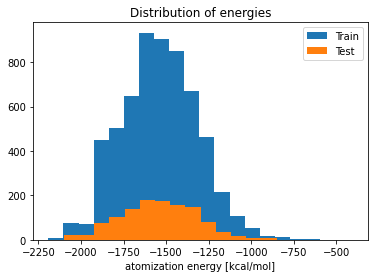

In [3]:
mean_y = np.mean(y_train)
scale_y = np.std(y_train)
print(f"X_train.shape={X_train.shape}; X_test.shape={X_test.shape}")
print(f"Y_train.shape={y_train.shape}; Y_test.shape={y_train.shape}")
print(f"Energies: ({mean_y} +- {scale_y}) kcal/mol")
plt.figure()
plt.hist(y_train, bins=20, label="Train")
plt.hist(y_test, bins=20, label="Test")
plt.legend()
plt.title("Distribution of energies")
plt.xlabel("atomization energy [kcal/mol]")

Our model will consist of two parts:
1. **Calculating feature vectors** from the raw input
2. **Applying a multi-layer-perceptron** to the obtained features

For the feature vectors we follow the approach proposed by Rupp et al. in 2012: We compute the eigvalues of the Coulomb matrix $C$:

$$C_{ii} = \frac{1}{2}Z_i^{2.4} \qquad C_{ij} = \frac{Z_i Z_j}{|R_i - R_j|}$$


The multi-layer perceptron consists of multiple rounds of a linear transformation and a non-linear function:
$$x_{n+1} = \sigma(x_n W_n + b_n)$$

In [4]:
def calculate_input_features(x):
    return jnp.linalg.eigvalsh(x)

def mlp(params, x):
    for ind_layer, (weights, bias) in enumerate(params):
        x = x @ weights + bias
        if ind_layer != (len(params) - 1):
            x = jax.nn.relu(x)
    return x

def model(params, x):
    x = calculate_input_features(x)
    y = mlp(params, x)
    y = y * scale_y + mean_y
    return y.flatten()

def init_mlp(n_neurons, input_dim, output_dim):
    dims_in = [input_dim] + n_neurons
    dims_out = n_neurons + [output_dim]
    params = []
    for dim_in, dim_out in zip(dims_in, dims_out):
        w_init = np.random.normal(loc=0, scale=2/(dim_in + dim_out), size=(dim_in, dim_out))
        b_init = np.zeros(shape=(dim_out,))
        params.append((w_init, b_init))
    return params

To optimize the model, we need to define a loss. For this task, we will use the standard mean square error:

In [5]:
# Define a loss function and an optimizer / training-step
def loss_func(params, x, y_target):
    y_pred = model(params, x)
    residual = (y_pred - y_target) / scale_y
    return jnp.mean(residual**2)


To optimize the model we will use plain stochastic gradient descent with learning rate $\eta$ to update our parameters $\theta$:

$$\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L_t}$$

In [6]:
@jax.jit # equivalent to training_step = jax.jit(training_step)
def training_step(params, batch, learning_rate):
    x, y_target = batch
    loss, grad = jax.value_and_grad(loss_func, argnums=0)(params, x, y_target)

    # Because the grad and params are nested data structures we cannot directly work with them
    # (e.g. new_params = params - learning_rate * grad), but need to
    param_update = jax.tree_map(lambda g: -learning_rate * g, grad)
    new_params = jax.tree_map(jnp.add, params, param_update)
    return loss, new_params

def make_batches(x, y, batch_size):
    indices = np.random.permutation(len(x))
    x = x[indices]
    y = y[indices]
    for k in range(0, len(x), batch_size):
        yield x[k:k+batch_size], y[k:k+batch_size]

During and after the training we will want to evaluate our model's performance, by applying it to some data and computing the mean absolute error to the ground truth:

In [7]:
@jax.jit
def evaluate_model(params, X, y_target):
    y_pred = model(params, X)
    return y_pred, jnp.mean(jnp.abs(y_pred - y_target))


The training loop consists of two nested loops:
- The outer loop runs over epochs. One epoch means having seen each sample in the training set once
- The inner loop runs over batches within the epoch: We split the whole training set into smaller, randomly selected batches to obtain cheaper/faster gradients

In [8]:
# Initialize the network and run the actual training
n_neurons_per_layer = [50, 50, 20]
learning_rate = 0.02
batch_size = 200
n_epochs = 100
params = init_mlp(n_neurons_per_layer, input_dim=X_train.shape[-1], output_dim=1)
params_averaged = params

mae_test = np.zeros(n_epochs)
mae_train = np.zeros(n_epochs)
loss = np.zeros(n_epochs * n_train // batch_size)
ind_step = 0
for ind_epoch in range(n_epochs):
    for batch in make_batches(X_train, y_train, batch_size):
        loss[ind_step], params = training_step(params, batch, learning_rate)
        ind_step += 1
    y_pred_train, mae_train[ind_epoch] = evaluate_model(params, X_train, y_train)
    y_pred_test, mae_test[ind_epoch] = evaluate_model(params, X_test, y_test)
    if (ind_epoch % 5) == 0:
        print(f"epoch={ind_epoch:<3d}, mae_train={mae_train[ind_epoch]:.1f} kcal/mol, mae_test={mae_test[ind_epoch]:.1f} kcal/mol")

# Analyze final model
print(f"Mean absolute error (MAE) on training set: {mae_train[-1]:.1f} kcal/mol")
print(f"Mean absolute error (MAE) on test set   : {mae_test[-1]:.1f} kcal/mol")

epoch=0  , mae_train=175.6 kcal/mol, mae_test=178.0 kcal/mol
epoch=5  , mae_train=153.9 kcal/mol, mae_test=157.5 kcal/mol
epoch=10 , mae_train=144.6 kcal/mol, mae_test=149.5 kcal/mol
epoch=15 , mae_train=153.5 kcal/mol, mae_test=158.7 kcal/mol
epoch=20 , mae_train=146.9 kcal/mol, mae_test=152.5 kcal/mol
epoch=25 , mae_train=127.9 kcal/mol, mae_test=133.0 kcal/mol
epoch=30 , mae_train=141.4 kcal/mol, mae_test=142.0 kcal/mol
epoch=35 , mae_train=122.1 kcal/mol, mae_test=126.3 kcal/mol
epoch=40 , mae_train=120.4 kcal/mol, mae_test=124.3 kcal/mol
epoch=45 , mae_train=120.9 kcal/mol, mae_test=122.4 kcal/mol
epoch=50 , mae_train=125.0 kcal/mol, mae_test=127.4 kcal/mol
epoch=55 , mae_train=114.5 kcal/mol, mae_test=117.8 kcal/mol
epoch=60 , mae_train=140.8 kcal/mol, mae_test=144.4 kcal/mol
epoch=65 , mae_train=109.7 kcal/mol, mae_test=112.8 kcal/mol
epoch=70 , mae_train=131.3 kcal/mol, mae_test=134.9 kcal/mol
epoch=75 , mae_train=107.8 kcal/mol, mae_test=111.6 kcal/mol
epoch=80 , mae_train=114

After training we can plot the learning curves, as well as a scatter plot of our final model's performance:

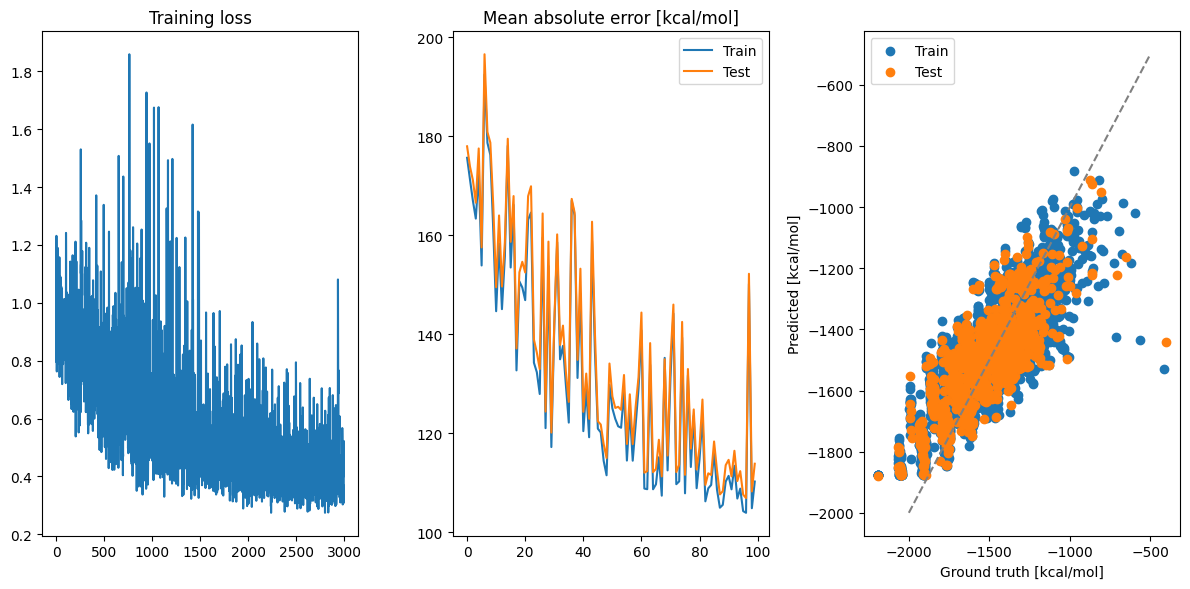

In [9]:
plt.close("all")
fig, axes = plt.subplots(1,3, dpi=100, figsize=(12,6))
axes[0].plot(loss)
axes[0].set_title("Training loss")

axes[1].plot(mae_train, label="Train")
axes[1].plot(mae_test, label="Test")
axes[1].set_title("Mean absolute error [kcal/mol]")
axes[1].legend()

axes[2].scatter(y_train, y_pred_train, label="Train")
axes[2].scatter(y_test, y_pred_test, label="Test")
axes[2].legend()
axes[2].set_xlabel("Ground truth [kcal/mol]")
axes[2].set_ylabel("Predicted [kcal/mol]")
axes[2].plot([-2000, -500], [-2000, -500], color='gray', ls='--')
fig.tight_layout()